In [1]:
import os
import os.path as osp
import dotenv
import pandas as pd
import numpy as np
import dotenv
import collections
from snorkel import SnorkelSession
from tcre.env import *
from tcre.supervision import *
session = SnorkelSession()
classes = get_candidate_classes()

REL_INDCK, REL_SECCK, REL_INDTF = 'indck', 'secck', 'indtf'
REL_ABBRS = collections.OrderedDict([
    (REL_INDCK, REL_CLASS_INDUCING_CYTOKINE),
    (REL_SECCK, REL_CLASS_SECRETED_CYTOKINE),
    (REL_INDTF, REL_CLASS_INDUCING_TRANSCRIPTION_FACTOR),
])

In [2]:
from snorkel.models import Candidate
c = session.query(classes.inducing_cytokine.subclass).first()
c.get_cids(), c.cytokine_cid, c.immune_cell_type_cid

(('CKAD8334A7AD4B4D2F:CK6FE135B3F86FB707',
  'CTE7B12DC660323A0E:CTE7B12DC660323A0E'),
 'CKAD8334A7AD4B4D2F:CK6FE135B3F86FB707',
 'CTE7B12DC660323A0E:CTE7B12DC660323A0E')

In [3]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    get_left_tokens,
    get_right_tokens,
    get_between_tokens,
    get_text_splits,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

### Text Pattern Functions

In [4]:
TERMS = get_terms_map()

def subst_pattern(pattern, terms=None):
    for k, v in {**TERMS, **(terms or {})}.items():
        pattern = pattern.replace('{{' + k + '}}', v)
    return pattern

def regex_pattern(pattern, terms=None):
    return regex_search(None, pattern, terms=terms, pattern_only=True)
    
def regex_search(c, pattern, terms=None, pattern_only=False):
    # Add possible "cell" token after each cell type reference
    pattern = pattern.replace('{{B}}', '{{B}}( cell| type cell|-type cell)?')
    
    # Apply generic replacements in pattern
    pattern = subst_pattern(pattern, terms=terms)
    
    if pattern_only:
        return pattern
    return rule_regex_search_tagged_text(c, pattern, 1)

TERMS

{'r_diff_n': '(differentiation|formation|generation|polarization|development|induction)',
 'r_diff_v': '(differentiate|form|generate|polarize|develop|differentiates|forms|generates|polarizes|develops)',
 'r_diff_p': '(differentiated|formed|generated|polarized|developed)',
 'r_diff_g': '(differentiating|forming|generating|polarizing|developing)',
 'r_push_n': '(inducer|driver|director|regulator|controller|promoter|mediator|mediater)',
 'r_push_v': '(induce|drive|direct|regulate|control|promote|mediate|induces|drives|directs|regulates|controls|promotes|mediates)',
 'r_push_p': '(induced|drove|driven|directed|regulated|controlled|promoted|mediated)',
 'r_push_g': '(inducing|driving|directing|regulating|controlling|promoting|mediating)',
 'r_prod_n': '(producer|production|generator|generation|creator|creation)',
 'r_prod_v': '(produce|generate|create|produces|generates|creates)',
 'r_prod_p': '(produced|generated|created)',
 'r_prod_g': '(producing|generating|creating)',
 'r_secr_n': '(sec

In [5]:
# LF_REGEX[REL_CLASS_INDUCING_CYTOKINE]['positive'][23]

In [6]:
def add_lf(fn, name=None):
    if name is not None:
        fn.__name__ = name
    # Register function in global namespace
    globals()[fn.__name__] = fn
        
def get_fn(ptn, sign):
    sub_ptn = regex_search(c, ptn[0], terms=ptn[1] if len(ptn)>1 else None, pattern_only=True)
    def fn(c):
        return sign * regex_search(c, ptn[0], terms=ptn[1] if len(ptn)>1 else None)
    return fn, sub_ptn

def get_agg_fn(ptns, sign, agg):
    fns = [get_fn(ptn, sign)[0] for ptn in ptns]
    def fn(c):
        return agg([f(c) for f in fns])
    return fn

# Set to true to roll all text pattern functions into a single function 
# (since there can be > 30 of them)
use_single_text_pattern_fn = True
if use_single_text_pattern_fn:
    for rcls in LF_REGEX:
        cmap = {v: k for k, v in REL_ABBRS.items()}
        for sign in LF_REGEX[rcls]:
            val = {'positive': 1, 'negative': -1}[sign]
            ptns = LF_REGEX[rcls][sign]
            if len(ptns) == 0:
                continue
            agg = max if val == 1 else min
            add_lf(get_agg_fn(ptns, val, agg), 'LF_{}_txtptn_{}_all'.format(cmap[rcls], sign[:3]))
else:
    for rcls in LF_REGEX:
        cmap = {v: k for k, v in REL_ABBRS.items()}
        for sign in LF_REGEX[rcls]:
            for i, ptn in enumerate(LF_REGEX[rcls][sign]):
                val = {'positive': 1, 'negative': -1}[sign]
                fn_name = 'LF_{}_txtptn_{}_{}'.format(cmap[rcls], sign[:3], i + 1)
                fn, sub_ptn = get_fn(ptn, val)
                print(fn_name, ':\n\t', ptn[0], '\n\t', sub_ptn)
                add_lf(fn, fn_name)


In [7]:
# text = 'The current {{A}}-(pos) cells'
# pattern = regex_pattern(r'{{A}}(\+|-)?(positive|negative|\(pos\)|neg|hi|lo)')
# print(pattern)
# m = re.search(pattern, text, flags=re.I)
# m is not None, m

### Heuristic Functions

In [8]:
# Universal function to check for references that are over a certain number of words away, 
# making them unlikely to have any kind of relationship
def is_ref_too_far(c, max_words=25):
    n = len(list(get_between_tokens(c)))
    return -1 if n > max_words else 0
for abbr in REL_ABBRS:
    add_lf(lambda c: is_ref_too_far(c), 'LF_' + abbr + '_heur_distref')

# * This heuristic seems too inaccurate to be useful *
# add_lf(lambda c: is_a_before_b(c), 'LF_indck_heur_a_before_b')    # Often mentioned as cytokine induces cell 
# add_lf(lambda c: -1*is_a_before_b(c), 'LF_secck_heur_a_before_b') # Order reversed typically (i.e. cell then cytokine)


def get_kwds(term_prefixes):
    return set([ 
        kw
        for prefix in term_prefixes
        for k, v in TERMS.items() if k.startswith(prefix)
        for kw in re.findall('\w+', v)
    ])

INDCK_KWS = get_kwds(['r_push', 'r_diff'])
SECCK_KWS = get_kwds(['r_secr'])
INDTF_KWS = get_kwds(['r_diff'])
INDCK_KWS = INDCK_KWS.difference(SECCK_KWS)
SECCK_KWS = SECCK_KWS.difference(INDCK_KWS)

             
def has_kwds(c, kwds, window=5):
    words = list(get_left_tokens(c, window=window)) + list(get_between_tokens(c)) + list(get_right_tokens(c, window=window))
    return len(kwds.intersection(words)) > 0

def LF_indck_heur_kwds(c):
    f1, f2 = has_kwds(c, INDCK_KWS), has_kwds(c, SECCK_KWS)
    if f1 and not f2:
        return 1
    if f2 and not f1:
        return -1
    return 0

def LF_secck_heur_kwds(c):
    return -1 * LF_indck_heur_kwds(c)

# Ignore due to ~30% accuracy
def LF_indtf_heur_kwds(c):
    return 1 if has_kwds(c, INDTF_KWS) else -1
        
def LF_indck_heur_closer_ck_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_indck_heur_closer_ct_to_ck(c):
    return -1*has_closer_reference(c, right=False)

def LF_indck_heur_closer_ref(c):
    return min(LF_indck_heur_closer_ck_to_ct(c), LF_indck_heur_closer_ct_to_ck(c))

def LF_secck_heur_closer_ck_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_secck_heur_closer_ct_to_ck(c):
    return -1*has_closer_reference(c, right=False)

def LF_secck_heur_closer_ref(c):
    return min(LF_secck_heur_closer_ck_to_ct(c), LF_secck_heur_closer_ct_to_ck(c))

def LF_indtf_heur_closer_tf_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_indtf_heur_closer_ct_to_tf(c):
    return -1*has_closer_reference(c, right=False)

def LF_indtf_heur_closer_ref(c):
    return min(LF_indtf_heur_closer_tf_to_ct(c), LF_indtf_heur_closer_ct_to_tf(c))

### Distant Supervision Functions

In [9]:
df_ix = pd.read_csv(osp.join(SUPERVISION_DATA_DIR, 'immunexpresso', 'data.csv'))

# Filter to records with known cell/cytokine mappings for internal IDS
df_ix = df_ix[df_ix['cell_ref_id'].notnull() & df_ix['cytokine_ref_id'].notnull()]

# Also filter to records with >= 8 publications for stronger relationships
df_ix = df_ix[df_ix['num_papers'] >= 8]
print(df_ix.info())
df_ix = df_ix.set_index(['cell_ref_id', 'cytokine_ref_id']).sort_index()

def is_known_ix_relation(c, actor, category):
    # Actor = 'cytokine' implies induction relationship where category in ['Positive', 'Negative', 'Unknown']
    # Actor = 'cell' implies secreation relationship and category is always 'Positive'
    
    # Split ids saved as "<matched id>:<preferred id>" to do lookup on preferred id
    ct_id, ck_id = c.immune_cell_type_cid, c.cytokine_cid
    ct_id, ck_id = ct_id.split(':')[1], ck_id.split(':')[1]
    if (ct_id, ck_id) in df_ix.index:
        df = df_ix.loc[(ct_id, ck_id)]
        df = df[(df['actor'] == actor) & (df['category'] == category)]
        return len(df) > 0
    return None

def LF_indck_dsup_imexpresso(c):
    if c.type != classes.inducing_cytokine.field:
        return 0
    ind1 = is_known_ix_relation(c, 'cytokine', 'Positive')
    if ind1 is None:
        return 0
    ind2 = is_known_ix_relation(c, 'cytokine', 'Negative')
    ind3 = is_known_ix_relation(c, 'cell', 'Positive')
    if ind1:
        if not ind2 and not ind3:
            return 1
    else:
        if ind2 or ind3:
            return -1
    return 0

def LF_secck_dsup_imexpresso(c):
    if c.type != classes.secreted_cytokine.field:
        return 0
    ind1 = is_known_ix_relation(c, 'cell', 'Positive')
    if ind1 is None:
        return 0
    ind2 = is_known_ix_relation(c, 'cytokine', 'Positive')
    ind3 = is_known_ix_relation(c, 'cytokine', 'Negative')
    if ind1:
        if not ind2 and not ind3:
            return 1
    else:
        if ind2 or ind3:
            return -1
    return 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 13 to 206
Data columns (total 10 columns):
actor              67 non-null object
category           67 non-null object
cell_id            67 non-null object
cell_label         67 non-null object
cytokine_id        67 non-null object
cytokine_label     67 non-null object
num_papers         67 non-null int64
score              67 non-null float64
cell_ref_id        67 non-null object
cytokine_ref_id    67 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 5.8+ KB
None


In [10]:
#df_ix.head()
#df_ix[df_ix['cell_label'] == 'T-helper 9 cell']

In [11]:
#dft = df_ix[(df_ix['actor'] == 'cytokine') & (df_ix['category'] == 'Positive')].sort_values('num_papers', ascending=False)
dft = df_ix[(df_ix['actor'] == 'cell') & (df_ix['category'] == 'Positive')].sort_values('num_papers', ascending=False)
#dft[dft['cell_label'] == 'T-helper 1 cell'].head(10)
dft[dft['cell_label'] == 'T-helper 2 cell'].head(10)

actor  category     cell_id  \
cell_ref_id        cytokine_ref_id                                  
CTE7B12DC660323A0E CK6FE135B3F86FB707  cell  Positive  CL_0000546   
                   CK128EC732B281BF60  cell  Positive  CL_0000546   
                   CKC5CC1A269C01EC48  cell  Positive  CL_0000546   
                   CK3B4A795DF4150CF4  cell  Positive  CL_0000546   
                   CK7026891CEAA3C8F9  cell  Positive  CL_0000546   

                                            cell_label cytokine_id  \
cell_ref_id        cytokine_ref_id                                   
CTE7B12DC660323A0E CK6FE135B3F86FB707  T-helper 2 cell     CID_131   
                   CK128EC732B281BF60  T-helper 2 cell      CID_83   
                   CKC5CC1A269C01EC48  T-helper 2 cell      CID_93   
                   CK3B4A795DF4150CF4  T-helper 2 cell     CID_128   
                   CK7026891CEAA3C8F9  T-helper 2 cell     CID_132   

                                      cytokine_label  num_papers  score  
cell_ref_id        cytokine_ref_id                                       
CTE7B12DC660323A0E CK6FE135B3F86FB707            IL4          59  15.88  
                   CK128EC732B281BF60           IFNG          12   0.99  
                   CKC5CC1A269C01EC48           IL10          11   2.39  
                   CK3B4A795DF4150CF4           IL33           8  14.52  
                   CK7026891CEAA3C8F9            IL5           8   7.20

### Supervised Classifier Functions

In [12]:
# from snorkel.models import Context
# session.query(Context).filter(Context.id == 72962).all()

In [24]:
df_sup_pred = pd.read_csv(osp.join(RESULTS_DATA_DIR, 'training-dev', 'run1', 'predictions.csv'))
df_sup_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243844 entries, 0 to 243843
Data columns (total 5 columns):
id        243844 non-null int64
y_true    243844 non-null int64
y_pred    243844 non-null float64
task      243844 non-null object
cfg       243844 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 9.3+ MB


In [25]:
#df_sup_pred[(df_sup_pred['cfg'] == 0) & df_sup_pred['id'].isin([30260, 30654, 31005, 31076, 31111, 31306, 31340, 31352, 31548, 31625])].sort_values('id')

In [27]:
def get_base_sup_fn(task, cfg):
    preds = df_sup_pred.pipe(lambda df: df[(df['task'] == task) & (df['cfg'] == cfg)]).set_index('id')['y_pred'].to_dict()
    def fn(c):
        if c.type != task:
            raise ValueError(f'Expecting task type {task} got {c.type}')
        if c.id not in preds:
            raise ValueError(f'Failed to find candidate {c.id} for task {task} and model cfg {cfg}')
        return 1 if preds[c.id] > .5 else -1
    return fn

for k, v in REL_ABBRS.items():
    for cfg in df_sup_pred['cfg'].unique():
        fn = get_base_sup_fn(classes[v].field, cfg)
        add_lf(fn, f'LF_{k}_sup_cfg_{cfg:02d}')

In [120]:
# c = session.query(classes.inducing_transcription_factor.subclass).first()
# LF_indtf_sup_cfg_00(c)

#### LF Testing

In [12]:
# c = session.query(candidate_class).filter(candidate_class.id == 32753).all()[0]
# c.cytokine_cid, c.immune_cell_type_cid

In [13]:
#df_ix.loc[('CTC3A8C3CBC245616A', 'CKB4EB2D2CC8BBB93D')]

In [14]:
from snorkel.viewer import SentenceNgramViewer
from snorkel.annotations import load_gold_labels

#candidate_class = classes.inducing_cytokine
#candidate_class = classes.secreted_cytokine
candidate_class = classes.inducing_transcription_factor
# Load all dev labels for this relation class
L_dev = load_gold_labels(
    session, annotator_name=candidate_class.field, 
    split=SPLIT_DEV, load_as_array=False, 
    cids_query=get_cids_query(session, candidate_class, SPLIT_DEV)
)
# Filter to get list of candidates where label is positive
L_dev_pos_cands = [L_dev.get_candidate(session, i) for i in np.argwhere(L_dev.toarray().squeeze()).squeeze()]

In [15]:
cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 1).all()
labeled, gold = [], []
gold_ids = [c.id for c in L_dev_pos_cands]
for c in cands:
    if LF_indtf_txtptn_pos_all(c) == 1:
        labeled.append(c)
        if c.id in gold_ids:
            gold.append(c)
    #gold.append(c)

print("Number labeled =", len(labeled), ", num gold =", len(gold))
# - ID in hover state is sentence id (c.get_parent().id)
# - Cell type label will be blue if candidate is NOT in "gold" set and red otherwise
SentenceNgramViewer(labeled, session, gold=gold)

Number labeled = 78 , num gold = 50


<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[15], [75], [49, 50]], [[4], [46], [45]], [[11, 12, 64, 65], [74], [41]], [[5, 23, …

In [20]:
#pd.Series([c.transcription_factor.get_span() for c in cands]).value_counts()

In [17]:
from snorkel.models import Sentence
s = session.query(Sentence).filter(Sentence.id==10687).one()
s

Sentence(Document PMC5052263,9,b'We also observed an expansion of PLZF+ expressing CD3+ thymocyte population in the absence of NFAT2 and increased IL-4 production.')

In [34]:
def get_candidates(sent_ids):
    cands = session.query(candidate_class.subclass)\
        .filter(candidate_class.subclass.split == 1).all()
    return [c for c in cands if c.get_parent().id in sent_ids]
sent_cands = get_candidates([10687])
c = sent_cands[0]
#sent_cands = [c for c in sent_cands if c.get_contexts()[0].get_span() == 'IL-6']
#sent_cands
c

### Composite Functions

In [28]:
def _global_lfs():
    return {
        k:v for k, v in globals().items() 
        if callable(v) and k.startswith('LF_')
    }

def get_lfs(filter_fn=None): 
    lfs = _global_lfs()
    if filter_fn is None:
        filter_fn = lambda n: True
    res = collections.OrderedDict([
        (k, lfs[k]) for k in sorted(lfs.keys()) 
        if filter_fn(k)
    ])
    return res

fns_indck_comp_pos = get_lfs(lambda k: k.startswith('LF_indck_txtptn_pos'))
fns_secck_comp_pos = get_lfs(lambda k: k.startswith('LF_secck_txtptn_pos'))
fns_indtf_comp_pos = get_lfs(lambda k: k.startswith('LF_indtf_txtptn_pos'))

def summarize_fns(name, fns):
    print('{}: Num functions found = {}, Names:\n{}'.format(
        name, len(fns), '\n'.join(list(fns.keys()))
    ))
summarize_fns('fns_indck_comp_pos', fns_indck_comp_pos)
summarize_fns('fns_secck_comp_pos', fns_secck_comp_pos)
summarize_fns('fns_indtf_comp_pos', fns_indtf_comp_pos)

def LF_indck_comp_neg_sec(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return min(-1*max([f(c) for f in fns_secck_comp_pos.values()]), 0)

def LF_secck_comp_neg_ind(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return min(-1*max([f(c) for f in fns_indck_comp_pos.values()]), 0)

fns_indck_comp_neg = get_lfs(lambda k: k.startswith('LF_indck_txtptn_neg') or \
                             k.startswith('LF_indck_heur_distref') or \
                             k.startswith('LF_indck_heur_closer_ct_to_ck') or \
                             k.startswith('LF_indck_comp_neg_sec'))
fns_secck_comp_neg = get_lfs(lambda k: k.startswith('LF_secck_txtptn_neg') or \
                             k.startswith('LF_secck_heur_distref') or \
                             k.startswith('LF_secck_heur_closer_ct_to_ck') or \
                             k.startswith('LF_secck_comp_neg_ind'))
fns_indtf_comp_neg = get_lfs(lambda k: k.startswith('LF_indtf_txtptn_neg') or \
                             k.startswith('LF_indtf_heur_distref') or \
                             k.startswith('LF_indtf_heur_closer_ct_to_tf'))
summarize_fns('fns_indck_comp_neg', fns_indck_comp_neg)
summarize_fns('fns_secck_comp_neg', fns_secck_comp_neg)
summarize_fns('fns_indtf_comp_neg', fns_indtf_comp_neg)

def apply_composite_xor_indck(c):
    is_secck = max([f(c) for f in fns_secck_comp_pos.values()]) > 0
    is_indck = max([f(c) for f in fns_indck_comp_pos.values()]) > 0
    not_secck = min([f(c) for f in fns_secck_comp_neg.values()]) < 0
    not_indck = min([f(c) for f in fns_indck_comp_neg.values()]) < 0
    # Look first for single strong positive prediction
    if is_secck and is_indck:
        return 0
    if is_indck and not is_secck:
        return 1
    if not is_indck and is_secck:
        return -1
    # If neither have positive prediction, look for strong negative prediction
    if not_secck == not_indck:
        return 0
    if not_indck and not not_secck:
        return -1
    return 1

def LF_indck_comp_xor(c):
    return apply_composite_xor_indck(c)

def LF_secck_comp_xor(c):
    return -1*apply_composite_xor_indck(c)

def LF_indtf_comp_xor(c):
    is_indtf = max([f(c) for f in fns_indtf_comp_pos.values()]) > 0
    not_indtf = min([f(c) for f in fns_indtf_comp_neg.values()]) < 0
    # Take non-conflicting positive or negative classifications and make 0 otherwise
    if is_indtf and not not_indtf:
        return 1
    if not_indtf and not is_indtf:
        return -1
    return 0

# Distant supervision composites
def LF_indck_comp_imexpresso_nonneg(c):
    skip = min([f(c) for f in fns_indck_comp_neg.values()]) < 0
    return LF_indck_dsup_imexpresso(c) if not skip else 0

def LF_secck_comp_imexpresso_nonneg(c):
    skip = min([f(c) for f in fns_secck_comp_neg.values()]) < 0
    return LF_secck_dsup_imexpresso(c) if not skip else 0

# Direct supervision composites
fns_indck_sup = get_lfs(lambda k: k.startswith('LF_indck_sup_cfg_'))
fns_secck_sup = get_lfs(lambda k: k.startswith('LF_secck_sup_cfg_'))
fns_indtf_sup = get_lfs(lambda k: k.startswith('LF_indtf_sup_cfg_'))
summarize_fns('fns_indck_sup', fns_indck_sup)
summarize_fns('fns_secck_sup', fns_secck_sup)
summarize_fns('fns_indtf_sup', fns_indtf_sup)

def LF_indck_sup_comp(c):
    # If there is any strong indication of a negative, use it instead
    not_indck = min([f(c) for f in fns_indck_comp_neg.values()]) < 0
    if not_indck:
        return -1
    
    # Otherwise, only return predictions when they agree
    preds = [f(c) for f in fns_indck_sup.values()]
    if len(set(preds)) == 1:
        return 1 if preds[0] > 0 else -1
    return 0

def LF_secck_sup_comp(c):
    # If there is any strong indication of a negative, use it instead
    not_secck = min([f(c) for f in fns_secck_comp_neg.values()]) < 0
    if not_secck:
        return -1
    
    # Otherwise, only return predictions when they agree
    preds = [f(c) for f in fns_secck_sup.values()]
    if len(set(preds)) == 1:
        return 1 if preds[0] > 0 else -1
    return 0

def LF_indtf_sup_comp(c):
    # Return predictions when they agree
    preds = [f(c) for f in fns_indtf_sup.values()]
    if len(set(preds)) == 1:
        return 1 if preds[0] > 0 else -1
    return 0

fns_indck_comp_pos: Num functions found = 1, Names:
LF_indck_txtptn_pos_all
fns_secck_comp_pos: Num functions found = 1, Names:
LF_secck_txtptn_pos_all
fns_indtf_comp_pos: Num functions found = 1, Names:
LF_indtf_txtptn_pos_all
fns_indck_comp_neg: Num functions found = 4, Names:
LF_indck_comp_neg_sec
LF_indck_heur_closer_ct_to_ck
LF_indck_heur_distref
LF_indck_txtptn_neg_all
fns_secck_comp_neg: Num functions found = 4, Names:
LF_secck_comp_neg_ind
LF_secck_heur_closer_ct_to_ck
LF_secck_heur_distref
LF_secck_txtptn_neg_all
fns_indtf_comp_neg: Num functions found = 3, Names:
LF_indtf_heur_closer_ct_to_tf
LF_indtf_heur_distref
LF_indtf_txtptn_neg_all
fns_indck_sup: Num functions found = 2, Names:
LF_indck_sup_cfg_00
LF_indck_sup_cfg_01
fns_secck_sup: Num functions found = 2, Names:
LF_secck_sup_cfg_00
LF_secck_sup_cfg_01
fns_indtf_sup: Num functions found = 2, Names:
LF_indtf_sup_cfg_00
LF_indtf_sup_cfg_01


In [29]:
LFs = collections.OrderedDict()
LFs[REL_CLASS_INDUCING_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_indck')).values()
LFs[REL_CLASS_SECRETED_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_secck')).values()
LFs[REL_CLASS_INDUCING_TRANSCRIPTION_FACTOR] = get_lfs(lambda k: k.startswith('LF_indtf')).values()
for k in LFs:
    print('{} labeling functions:'.format(k))
    for f in LFs[k]:
        print(f.__name__)
    print()

InducingCytokine labeling functions:
LF_indck_comp_imexpresso_nonneg
LF_indck_comp_neg_sec
LF_indck_comp_xor
LF_indck_dsup_imexpresso
LF_indck_heur_closer_ck_to_ct
LF_indck_heur_closer_ct_to_ck
LF_indck_heur_closer_ref
LF_indck_heur_distref
LF_indck_heur_kwds
LF_indck_sup_cfg_00
LF_indck_sup_cfg_01
LF_indck_sup_comp
LF_indck_txtptn_neg_all
LF_indck_txtptn_pos_all

SecretedCytokine labeling functions:
LF_secck_comp_imexpresso_nonneg
LF_secck_comp_neg_ind
LF_secck_comp_xor
LF_secck_dsup_imexpresso
LF_secck_heur_closer_ck_to_ct
LF_secck_heur_closer_ct_to_ck
LF_secck_heur_closer_ref
LF_secck_heur_distref
LF_secck_heur_kwds
LF_secck_sup_cfg_00
LF_secck_sup_cfg_01
LF_secck_sup_comp
LF_secck_txtptn_neg_all
LF_secck_txtptn_pos_all

InducingTranscriptionFactor labeling functions:
LF_indtf_comp_xor
LF_indtf_heur_closer_ct_to_tf
LF_indtf_heur_closer_ref
LF_indtf_heur_closer_tf_to_ct
LF_indtf_heur_distref
LF_indtf_heur_kwds
LF_indtf_sup_cfg_00
LF_indtf_sup_cfg_01
LF_indtf_sup_comp
LF_indtf_txtptn_

## Apply Labeling to Candidates

In [30]:
for c in classes.values():
    for split in [SPLIT_DEV, SPLIT_TRAIN]:
        n = session.query(c.subclass).filter(c.subclass.split == split).count()
        print('Candidate counts: {} (split {}) -> {}'.format(c.name, split, n))

Candidate counts: InducingCytokine (split 1) -> 673
Candidate counts: InducingCytokine (split 0) -> 48656
Candidate counts: SecretedCytokine (split 1) -> 673
Candidate counts: SecretedCytokine (split 0) -> 48527
Candidate counts: InducingTranscriptionFactor (split 1) -> 410
Candidate counts: InducingTranscriptionFactor (split 0) -> 22983


In [34]:
from snorkel.models import Candidate
from snorkel.annotations import LabelAnnotator
from snorkel.annotations import load_gold_labels

def run_labeling(candidate_class, lfs, split, replace_key_set=True, has_gold_labels=False):
    cids_query = get_cids_query(session, candidate_class, split)
    y = None
    if has_gold_labels:
        y = load_gold_labels(
            session, annotator_name=candidate_class.field, 
            split=split, load_as_array=True, cids_query=cids_query)
        y = np.where(y > 0, 1, -1)
        assert np.all(np.in1d(y, [-1, 1]))
    
    print('Running labeling for class {}, split {}'.format(candidate_class.name, split))
    labeler = LabelAnnotator(lfs=lfs)
    X = labeler.apply(
        split=split, cids_query=cids_query, 
        replace_key_set=replace_key_set, key_group=candidate_class.index
    )
    stats = X.lf_stats(session, y)
    
    return X, y, stats, labeler

res_label = collections.defaultdict(dict)
for c in classes:
    if c not in LFs:
        continue
    for split in [SPLIT_DEV, SPLIT_TRAIN]:
#     for split in [SPLIT_DEV]:
        res_label[c][split] = run_labeling(
            classes[c], LFs[c], split, has_gold_labels=split>0
        )

  1%|          | 4/673 [00:00<00:19, 34.16it/s]

Running labeling for class InducingCytokine, split 1
Clearing existing...
Running UDF...


100%|██████████| 673/673 [00:19<00:00, 37.73it/s]


Running labeling for class InducingCytokine, split 0


  0%|          | 0/48656 [00:00<?, ?it/s]

Clearing existing...
Running UDF...


100%|██████████| 48656/48656 [24:02<00:00, 41.59it/s]


Running labeling for class SecretedCytokine, split 1
Clearing existing...


  1%|          | 5/673 [00:00<00:15, 43.38it/s]

Running UDF...


100%|██████████| 673/673 [00:20<00:00, 33.20it/s]


Running labeling for class SecretedCytokine, split 0


  0%|          | 0/48527 [00:00<?, ?it/s]

Clearing existing...
Running UDF...


100%|██████████| 48527/48527 [24:48<00:00, 32.61it/s]


Running labeling for class InducingTranscriptionFactor, split 1
Clearing existing...


  2%|▏         | 10/410 [00:00<00:04, 95.95it/s]

Running UDF...


  0%|          | 0/22983 [00:00<?, ?it/s]

Running labeling for class InducingTranscriptionFactor, split 0
Clearing existing...
Running UDF...


100%|██████████| 22983/22983 [04:15<00:00, 89.94it/s]


In [35]:
def add_f1(df, eps=1e-8):
    if 'Empirical Acc.' in df:
        precision = df['TP'] / (df['TP'] + df['FP'])
        recall = df['TP'] / (df['TP'] + df['FN'])
        df['Empirical F1'] = (2 * precision * recall) / (precision + recall + eps)
    return df

In [36]:
from IPython.display import display
for c in res_label:
    for split in res_label[c]:
        print('Stats {} (split {}):'.format(c, split))
        display(add_f1(res_label[c][split][2]))

Stats InducingCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Empirical F1
LF_indck_comp_imexpresso_nonneg,0,0.101040,0.101040,0.074294,9,3,14,42,0.750000,0.514286
LF_indck_comp_neg_sec,1,0.121842,0.121842,0.046062,0,0,2,80,0.975610,NaN
LF_indck_comp_xor,2,0.300149,0.300149,0.209510,73,48,1,80,0.757426,0.748718
LF_indck_dsup_imexpresso,3,0.188707,0.188707,0.120357,14,7,15,91,0.826772,0.560000
LF_indck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.175334,0,0,27,176,0.866995,NaN
LF_indck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.120357,0,0,7,162,0.958580,NaN
LF_indck_heur_closer_ref,6,0.396731,0.396731,0.219911,0,0,32,235,0.880150,NaN
LF_indck_heur_distref,7,0.230312,0.230312,0.068351,0,0,5,150,0.967742,NaN
LF_indck_heur_kwds,8,0.548291,0.548291,0.384844,84,153,0,132,0.585366,0.523364
LF_indck_sup_cfg_00,9,1.000000,1.000000,0.539376,39,153,94,387,0.632987,0.240000


Stats InducingCytokine (split 0):


,j,Coverage,Overlaps,Conflicts
LF_indck_comp_imexpresso_nonneg,0,0.106729,0.106729,0.062130
LF_indck_comp_neg_sec,1,0.145922,0.145922,0.061657
LF_indck_comp_xor,2,0.184068,0.184068,0.092918
LF_indck_dsup_imexpresso,3,0.204189,0.204189,0.107674
LF_indck_heur_closer_ck_to_ct,4,0.222378,0.222378,0.095610
LF_indck_heur_closer_ct_to_ck,5,0.158953,0.158953,0.071666
LF_indck_heur_closer_ref,6,0.298894,0.298894,0.135687
LF_indck_heur_distref,7,0.204887,0.204887,0.085580
LF_indck_heur_kwds,8,0.486785,0.486785,0.312418
LF_indck_sup_cfg_00,9,1.000000,1.000000,0.479448


Stats SecretedCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Empirical F1
LF_secck_comp_imexpresso_nonneg,0,0.105498,0.105498,0.090639,22,43,0,6,0.394366,0.505747
LF_secck_comp_neg_ind,1,0.182764,0.182764,0.068351,0,0,0,123,1.000000,NaN
LF_secck_comp_xor,2,0.300149,0.300149,0.151560,52,29,0,121,0.856436,0.781955
LF_secck_dsup_imexpresso,3,0.181278,0.181278,0.150074,23,78,0,21,0.360656,0.370968
LF_secck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.108470,0,0,11,192,0.945813,NaN
LF_secck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.095097,0,0,0,169,1.000000,NaN
LF_secck_heur_closer_ref,6,0.396731,0.396731,0.163447,0,0,11,256,0.958801,NaN
LF_secck_heur_distref,7,0.230312,0.230312,0.081724,0,0,2,153,0.987097,NaN
LF_secck_heur_kwds,8,0.548291,0.548291,0.264487,61,71,3,234,0.799458,0.622449
LF_secck_sup_cfg_00,9,1.000000,1.000000,0.456166,43,124,38,468,0.759287,0.346774


Stats SecretedCytokine (split 0):


,j,Coverage,Overlaps,Conflicts
LF_secck_comp_imexpresso_nonneg,0,0.133658,0.133658,0.111814
LF_secck_comp_neg_ind,1,0.035856,0.035856,0.011849
LF_secck_comp_xor,2,0.179611,0.179611,0.139798
LF_secck_dsup_imexpresso,3,0.193583,0.193583,0.163126
LF_secck_heur_closer_ck_to_ct,4,0.220722,0.220722,0.097760
LF_secck_heur_closer_ct_to_ck,5,0.158778,0.158778,0.070311
LF_secck_heur_closer_ref,6,0.297443,0.297443,0.136213
LF_secck_heur_distref,7,0.205185,0.205185,0.070250
LF_secck_heur_kwds,8,0.481196,0.481196,0.304161
LF_secck_sup_cfg_00,9,1.000000,1.000000,0.504647


Stats InducingTranscriptionFactor (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Empirical F1
LF_indtf_comp_xor,0,0.568293,0.568293,0.402439,45,14,7,167,0.909871,0.810811
LF_indtf_heur_closer_ct_to_tf,1,0.370732,0.370732,0.243902,0,0,4,148,0.973684,NaN
LF_indtf_heur_closer_ref,2,0.446341,0.446341,0.295122,0,0,10,173,0.945355,NaN
LF_indtf_heur_closer_tf_to_ct,3,0.263415,0.263415,0.187805,0,0,6,102,0.944444,NaN
LF_indtf_heur_distref,4,0.226829,0.226829,0.187805,0,0,3,90,0.967742,NaN
LF_indtf_heur_kwds,5,1.000000,1.000000,0.643902,63,122,23,202,0.646341,0.464945
LF_indtf_sup_cfg_00,6,1.000000,1.000000,0.643902,32,72,54,252,0.692683,0.336842
LF_indtf_sup_cfg_01,7,1.000000,1.000000,0.643902,32,88,54,236,0.653659,0.310680
LF_indtf_sup_comp,8,0.804878,0.804878,0.448780,23,49,45,213,0.715152,0.328571
LF_indtf_txtptn_neg_all,9,0.075610,0.075610,0.063415,0,0,7,24,0.774194,NaN


Stats InducingTranscriptionFactor (split 0):


,j,Coverage,Overlaps,Conflicts
LF_indtf_comp_xor,0,0.403907,0.403907,0.259192
LF_indtf_heur_closer_ct_to_tf,1,0.131271,0.131271,0.075882
LF_indtf_heur_closer_ref,2,0.219771,0.219771,0.128138
LF_indtf_heur_closer_tf_to_ct,3,0.130966,0.130966,0.073750
LF_indtf_heur_distref,4,0.170691,0.170691,0.089109
LF_indtf_heur_kwds,5,1.000000,1.000000,0.560327
LF_indtf_sup_cfg_00,6,1.000000,1.000000,0.560327
LF_indtf_sup_cfg_01,7,1.000000,1.000000,0.560327
LF_indtf_sup_comp,8,0.770700,0.770700,0.331027
LF_indtf_txtptn_neg_all,9,0.044207,0.044207,0.030414


## Train Generative Model

In [37]:
res_label.keys()

dict_keys(['InducingCytokine', 'SecretedCytokine', 'InducingTranscriptionFactor'])

In [38]:
from snorkel.learning.structure import DependencySelector
from snorkel.learning import GenerativeModel

res_train = {}
for c in res_label:
    print('Running generative model training for class {}'.format(c))
    ds = DependencySelector()
    split = 0
    X = res_label[c][split][0]
    deps = ds.select(X, threshold=0.1)
    gen_model = GenerativeModel(lf_propensity=True)
    gen_model.train(
        X, deps=deps, decay=0.95, 
        step_size=0.1/X.shape[0], reg_param=0.0
    )
    marginals = gen_model.marginals(X)
    res_train[c] = gen_model, X, marginals, deps

Running generative model training for class InducingCytokine
Inferred cardinality: 2
Running generative model training for class SecretedCytokine
Inferred cardinality: 2
Running generative model training for class InducingTranscriptionFactor
Inferred cardinality: 2


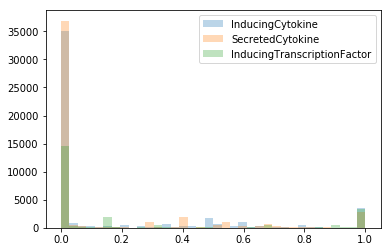

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
for c in res_train:
    plt.hist(res_train[c][2], bins=36, label=c, alpha=.3)
    plt.legend()

In [29]:
# from IPython.display import display
# for c in res_train:
#     print(c)
#     display(res_train[c][0].learned_lf_stats())

In [41]:
from snorkel.annotations import save_marginals

# Fetch the candidates for each class into a SINGLE list and do
# the same for the marginal arrays since the `save_marginals` function
# deletes all records (with no arguments for filters to avoid this) each time,
# making it impossible to call separately for each set of candidates
candidates, marginals = [], []
for c in res_train:
    X, y = res_train[c][1], res_train[c][2]
    candidates.extend([X.get_candidate(session, i) for i in range(X.shape[0])])
    marginals.append(y)
marginals = np.concatenate(marginals)
assert len(candidates) == len(marginals)
save_marginals(session, candidates, marginals)

Saved 120166 marginals


In [42]:
from snorkel.models import Marginal, Candidate

# Determine the candidate types for all saved marginals
cids = [m.candidate_id for m in session.query(Marginal).all()]
pd.DataFrame(
    session.query(Candidate.id, Candidate.type).filter(Candidate.id.in_(cids)),
    columns=['id', 'type']
).groupby('type').size()

type
inducing_cytokine                48656
inducing_transcription_factor    22983
secreted_cytokine                48527
dtype: int64

In [27]:
# from snorkel.models import LabelKey
# for lk in session.query(LabelKey).all():
#     print(lk.name, lk.group)

In [43]:
res_lf_stats = {}
for c in classes:
    print(c)
    candidate_class = classes[c]
    L_dev = res_label[c][1][0]
    L_gold_dev = res_label[c][1][1]
    gen_model_train = res_train[c][0]
    gen_model_train.error_analysis(session, L_dev, L_gold_dev)
    res_lf_stats[c] = L_dev.lf_stats(session, L_gold_dev, gen_model_train.learned_lf_stats()['Accuracy'])
    display(res_lf_stats[c])

InducingCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.256
Neg. class accuracy: 0.852
Precision            0.298
Recall               0.256
F1                   0.275
----------------------------------------
TP: 34 | FP: 80 | TN: 460 | FN: 99



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indck_comp_imexpresso_nonneg,0,0.101040,0.101040,0.074294,9,3,14,42,0.750000,0.583521
LF_indck_comp_neg_sec,1,0.121842,0.121842,0.046062,0,0,2,80,0.975610,0.669860
LF_indck_comp_xor,2,0.300149,0.300149,0.209510,73,48,1,80,0.757426,0.700000
LF_indck_dsup_imexpresso,3,0.188707,0.188707,0.120357,14,7,15,91,0.826772,0.696875
LF_indck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.175334,0,0,27,176,0.866995,0.796596
LF_indck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.120357,0,0,7,162,0.958580,0.739087
LF_indck_heur_closer_ref,6,0.396731,0.396731,0.219911,0,0,32,235,0.880150,0.826463
LF_indck_heur_distref,7,0.230312,0.230312,0.068351,0,0,5,150,0.967742,0.786478
LF_indck_heur_kwds,8,0.548291,0.548291,0.384844,84,153,0,132,0.585366,0.621863
LF_indck_sup_cfg_00,9,1.000000,1.000000,0.539376,39,153,94,387,0.632987,0.918575


SecretedCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.605
Neg. class accuracy: 0.899
Precision            0.45
Recall               0.605
F1                   0.516
----------------------------------------
TP: 49 | FP: 60 | TN: 532 | FN: 32



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_secck_comp_imexpresso_nonneg,0,0.105498,0.105498,0.090639,22,43,0,6,0.394366,0.480132
LF_secck_comp_neg_ind,1,0.182764,0.182764,0.068351,0,0,0,123,1.000000,0.629032
LF_secck_comp_xor,2,0.300149,0.300149,0.151560,52,29,0,121,0.856436,0.590698
LF_secck_dsup_imexpresso,3,0.181278,0.181278,0.150074,23,78,0,21,0.360656,0.533537
LF_secck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.108470,0,0,11,192,0.945813,0.808255
LF_secck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.095097,0,0,0,169,1.000000,0.762635
LF_secck_heur_closer_ref,6,0.396731,0.396731,0.163447,0,0,11,256,0.958801,0.841871
LF_secck_heur_distref,7,0.230312,0.230312,0.081724,0,0,2,153,0.987097,0.791498
LF_secck_heur_kwds,8,0.548291,0.548291,0.264487,61,71,3,234,0.799458,0.632645
LF_secck_sup_cfg_00,9,1.000000,1.000000,0.456166,43,124,38,468,0.759287,0.938561


InducingTranscriptionFactor
Scores (Un-adjusted)
Pos. class accuracy: 0.442
Neg. class accuracy: 0.818
Precision            0.392
Recall               0.442
F1                   0.415
----------------------------------------
TP: 38 | FP: 59 | TN: 265 | FN: 48



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indtf_comp_xor,0,0.568293,0.568293,0.402439,45,14,7,167,0.909871,0.764479
LF_indtf_heur_closer_ct_to_tf,1,0.370732,0.370732,0.243902,0,0,4,148,0.973684,0.752339
LF_indtf_heur_closer_ref,2,0.446341,0.446341,0.295122,0,0,10,173,0.945355,0.778874
LF_indtf_heur_closer_tf_to_ct,3,0.263415,0.263415,0.187805,0,0,6,102,0.944444,0.735061
LF_indtf_heur_distref,4,0.226829,0.226829,0.187805,0,0,3,90,0.967742,0.768227
LF_indtf_heur_kwds,5,1.000000,1.000000,0.643902,63,122,23,202,0.646341,0.755133
LF_indtf_sup_cfg_00,6,1.000000,1.000000,0.643902,32,72,54,252,0.692683,0.947583
LF_indtf_sup_cfg_01,7,1.000000,1.000000,0.643902,32,88,54,236,0.653659,0.912612
LF_indtf_sup_comp,8,0.804878,0.804878,0.448780,23,49,45,213,0.715152,0.952992
LF_indtf_txtptn_neg_all,9,0.075610,0.075610,0.063415,0,0,7,24,0.774194,0.580977


In [28]:
res_lf_stats = {}
for c in classes:
    print(c)
    candidate_class = classes[c]
    L_dev = res_label[c][1][0]
    L_gold_dev = res_label[c][1][1]
    gen_model_train = res_train[c][0]
    gen_model_train.error_analysis(session, L_dev, L_gold_dev)
    res_lf_stats[c] = L_dev.lf_stats(session, L_gold_dev, gen_model_train.learned_lf_stats()['Accuracy'])
    display(res_lf_stats[c])

InducingCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.624
Neg. class accuracy: 0.844
Precision            0.497
Recall               0.624
F1                   0.553
----------------------------------------
TP: 83 | FP: 84 | TN: 456 | FN: 50



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indck_comp_imexpresso_nonneg,0,0.101040,0.101040,0.049034,9,3,14,42,0.750000,0.667067
LF_indck_comp_neg_sec,1,0.121842,0.121842,0.005944,0,0,2,80,0.975610,0.705577
LF_indck_comp_xor,2,0.300149,0.300149,0.092125,73,48,1,80,0.757426,0.713648
LF_indck_dsup_imexpresso,3,0.188707,0.188707,0.074294,14,7,15,91,0.826772,0.690314
LF_indck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.124814,0,0,27,176,0.866995,0.784868
LF_indck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.078752,0,0,7,162,0.958580,0.766452
LF_indck_heur_closer_ref,6,0.396731,0.396731,0.151560,0,0,32,235,0.880150,0.816067
LF_indck_heur_distref,7,0.230312,0.194651,0.032689,0,0,5,150,0.967742,0.745604
LF_indck_heur_kwds,8,0.548291,0.419019,0.205052,84,153,0,132,0.585366,0.702112
LF_indck_txtptn_neg_all,9,0.063893,0.050520,0.037147,0,0,5,38,0.883721,0.693208


SecretedCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.901
Neg. class accuracy: 0.86
Precision            0.468
Recall               0.901
F1                   0.616
----------------------------------------
TP: 73 | FP: 83 | TN: 509 | FN: 8



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_secck_comp_imexpresso_nonneg,0,0.105498,0.105498,0.035661,22,43,0,6,0.394366,0.664533
LF_secck_comp_neg_ind,1,0.182764,0.182764,0.025260,0,0,0,123,1.000000,0.747107
LF_secck_comp_xor,2,0.300149,0.300149,0.046062,52,29,0,121,0.856436,0.716454
LF_secck_dsup_imexpresso,3,0.181278,0.181278,0.092125,23,78,0,21,0.360656,0.661765
LF_secck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.053492,0,0,11,192,0.945813,0.785413
LF_secck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.043091,0,0,0,169,1.000000,0.770089
LF_secck_heur_closer_ref,6,0.396731,0.396731,0.083210,0,0,11,256,0.958801,0.796423
LF_secck_heur_distref,7,0.230312,0.193165,0.044577,0,0,2,153,0.987097,0.758634
LF_secck_heur_kwds,8,0.548291,0.419019,0.126300,61,71,3,234,0.799458,0.763495
LF_secck_txtptn_neg_all,9,0.060921,0.047548,0.013373,0,0,1,40,0.975610,0.729555


InducingTranscriptionFactor
Scores (Un-adjusted)
Pos. class accuracy: 0.674
Neg. class accuracy: 0.836
Precision            0.523
Recall               0.674
F1                   0.589
----------------------------------------
TP: 58 | FP: 53 | TN: 271 | FN: 28



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indtf_comp_xor,0,0.568293,0.568293,0.241463,45,14,7,167,0.909871,0.807455
LF_indtf_heur_closer_ct_to_tf,1,0.370732,0.370732,0.180488,0,0,4,148,0.973684,0.743006
LF_indtf_heur_closer_ref,2,0.446341,0.446341,0.212195,0,0,10,173,0.945355,0.770688
LF_indtf_heur_closer_tf_to_ct,3,0.263415,0.263415,0.131707,0,0,6,102,0.944444,0.689339
LF_indtf_heur_distref,4,0.226829,0.226829,0.158537,0,0,3,90,0.967742,0.713839
LF_indtf_heur_kwds,5,1.000000,0.660976,0.295122,63,122,23,202,0.646341,0.907598
LF_indtf_txtptn_neg_all,6,0.075610,0.075610,0.043902,0,0,7,24,0.774194,0.615771
LF_indtf_txtptn_pos_all,7,0.190244,0.190244,0.080488,50,28,0,0,0.641026,0.710915


### Check Top Predictions

In [49]:
pcs = session.query(classes.inducing_cytokine.subclass).filter(classes.inducing_cytokine.subclass.split == SPLIT_TRAIN).all()
pcs = {c.id: c for c in pcs}
len(pcs)

48656

In [51]:
dfpcs = pd.DataFrame([dict(id=c.id, pred=c.marginals[0].probability) for c in pcs.values()])
dfpcs = dfpcs.sort_values('pred', ascending=False).head(25)

In [57]:
def get_rec(r):
    c = pcs[r['id']]
    return dict(id=r['id'], pred=r['pred'], s1=c.get_contexts()[0].get_span(), s2=c.get_contexts()[1].get_span(), sent=c.get_parent().text)
pd.set_option('display.max_colwidth', 200)
pd.DataFrame([get_rec(r) for _, r in dfpcs.iterrows()])

,id,pred,s1,s2,sent
0,251888.0,0.999931,IL-12,Th1,"In C57BL/6 mice, IL-12 is produced by T. muris infection and IL-12 and IL-18 promote IFN-γ-producing Th1 cell differentiation."
1,43321.0,0.999931,IL-12,Th1,. STAT1 was activated by autocrine IFN-γ whereas; STAT4 is mainly activated by IL-12 both of which are important for in vitro differentiation of Th1 cells.
2,255380.0,0.999931,IL-12,Th1,"IFN-γ-regulated IL-12 signalling drives Th1 differentiation, whereas CXCR3 contributes to the migration of Th1 cells."
3,159145.0,0.999931,IL-12,Th1,"In the absence of IL-12, IL-18-mediated effects on T cells may extend beyond Th1 differentiation to include Th2 cytokine production []. \n"
4,1756.0,0.999931,IL-12,Th1,"IL-12 is another important regulator of Th1 cell differentiation, and it is also the primary immunoregulatory factor secreted by Th1 cells."
5,94022.0,0.999931,IL-12,Th1,"T-bet promotes the expression of IFN-γ and IL-12Rb2, which, together with IL-12Rb1, form a functional IL-12 receptor complex to further stimulate IFN-γ-induced Th1 differentiation."
6,182560.0,0.999931,IL-12,Th1,"For example, IL-12 and IL-18 are important for differentiation of Th1 cells but also play a key role in innate immunity."
7,140490.0,0.999931,IL-12,Th1,"B10.S mice are genetically resistant to EAE; lymphocytes from B10.S mice did not generate IFN-γ in response to MBP, unless the cells were cultured in vitro in the presence of IL-12 [], a cytokine ..."
8,5758.0,0.999931,interleukin (IL)-12,Th1,T Helper Type 2 Cell Differentiation Occurs in the Presence of Interleukin 12 Receptor β2 Chain Expression and Signaling\n\nThe differentiation of CD4+ T cells into T helper type 1 (Th1) cells is ...
9,96699.0,0.999888,IL-12,Th1,"Whereas signaling of IL-12Rβ1β2 complex by IL-12 induces STAT4-dependent IFN-γ secretion with consequent Th1 differentiation , signaling of IL-4Rα by IL-4 induces STAT6-dependent IL-4 secretion wi..."
